In [1]:
import matplotlib.pyplot as plt
import numba
import numpy as np
from ripser import ripser
from scipy.spatial.distance import pdist, squareform
import umap
import torch
import plotly.graph_objects as go
from persim import plot_diagrams
import pandas as pd
from circular_cords import get_coords
from fix_umap_bug import fix_umap_bug

fix_umap_bug()

Import the data. "activity" is then a 50000xneurons matrix with all activations.

In [2]:
layer = "inception4d"
activity = np.load(f"activations/ILSVRC2015/{layer}.npy")
print(activity.shape)
neurons = activity.shape[1]

(50761, 528)


In [3]:
cluster_info = pd.read_pickle(f"data/perera/{layer}.pkl")
print(cluster_info.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34 entries, 11 to 23
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   cluster_id           34 non-null     int32  
 1   cluster_size         34 non-null     int64  
 2   cluster_members      34 non-null     object 
 3   longest_bar          34 non-null     float64
 4   Top 10 longest bars  34 non-null     object 
 5   circle_param         34 non-null     object 
 6   info_per_node        34 non-null     object 
dtypes: float64(1), int32(1), int64(1), object(4)
memory usage: 2.0+ KB
None


In [18]:
cluster_num = 3
cluster = activity[cluster_info["cluster_members"][cluster_num]]
print(cluster.shape)

(1213, 528)


In [19]:
layout2 = umap.UMAP(
    n_components=neurons, verbose=False, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(cluster)
M = squareform(pdist(layout2, "euclidean"))

In [20]:
maxdim = 1
coeff = 47
thresh = np.max(M[~np.isinf(M)])
persistence = ripser(
    M, maxdim=maxdim, coeff=coeff, do_cocycles=True, distance_matrix=True, thresh=thresh
)

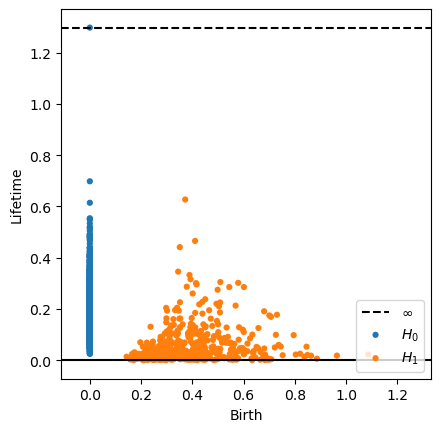

In [21]:
plot_diagrams(persistence["dgms"], lifetime=True, show=True)

In [22]:
f = cluster_info["circle_param"][cluster_num]

Use the code to compute a circular parameter for the identified circle using circular parametrization (de Silva):

In [23]:
layout_3d = umap.UMAP(
    n_components=3, verbose=False, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(cluster)

In [24]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=layout_3d[:, 0],
            y=layout_3d[:, 1],
            z=layout_3d[:, 2],
            mode="markers",
            marker=dict(
                size=12, color=f, colorscale="hsv", opacity=0.8, showscale=True
            ),
        )
    ]
)
# Cyclic colors: 'twilight', 'twilight_shifted', 'hsv', Default: Viridis
fig.update_layout(
    autosize=False, width=1000, height=700, margin=dict(l=0, r=0, b=0, t=0)
)
fig.write_html("circular_feature_3D.html")
fig.show()

In [ ]:
diagrams = persistence[
    "dgms"
]  # the multiset describing the lives of the persistence classes
cocycles = persistence["cocycles"][
    1
]  # the cocycle representatives for the 1-dim classes
births1 = diagrams[1][:, 0]  # the time of birth for the 1-dim classes
deaths1 = diagrams[1][:, 1]  # the time of death for the 1-dim classes
lives1 = deaths1 - births1  # the lifetime for the 1-dim classes
iMax = np.argsort(lives1)

circle_num = 1

threshold = births1[iMax[-circle_num]] + (
    deaths1[iMax[-circle_num]] - births1[iMax[-circle_num]]
) * (9 / 10)


f, theta_matrix, verts, num_verts = get_coords(
    cocycle=cocycles[iMax[-circle_num]],
    threshold=threshold,
    num_sampled=len(layout2),
    dists=M,
    coeff=coeff,
    bool_smooth_circle="perea",  # "graph", "old", "perea"
)

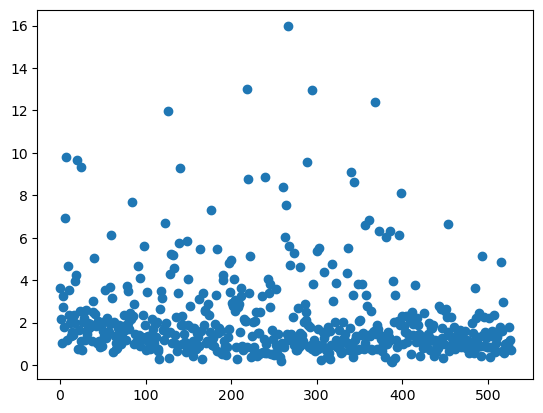

In [25]:
inform_rates = cluster_info["info_per_node"][cluster_num]
plt.scatter(range(neurons), inform_rates)
plt.show()

Not all neurons contribute equally to this circle. We identify the ones that tune to it: 

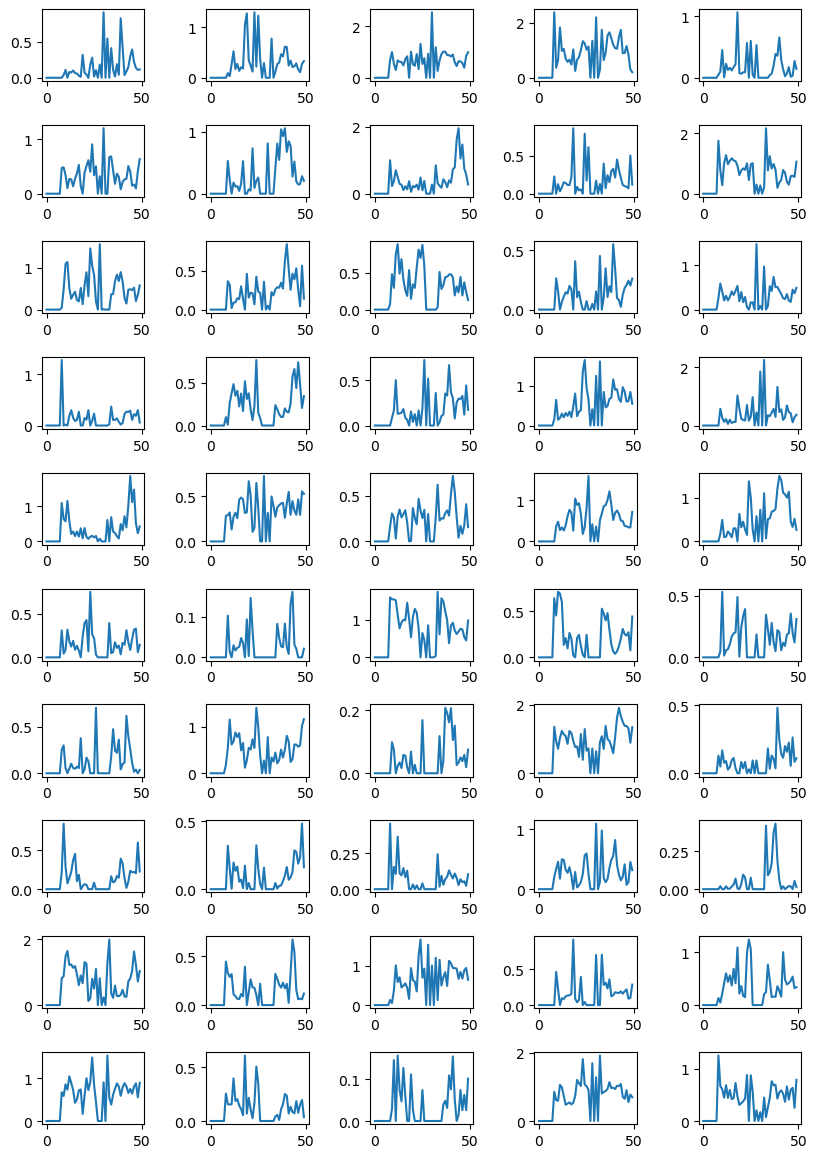

In [26]:
circ_rates = np.zeros([neurons, 50])
counts, bins = np.histogram(f, bins=50, density=True)
for b in range(len(bins) - 1):
    for n in range(neurons):
        rates = []
        for x in range(len(cluster)):
            if bins[b] < f[x] <= bins[b + 1]:
                rates.append(cluster[x, n])
        if rates:
            circ_rates[n, b] = np.mean(rates)
        else:
            circ_rates[n, b] = 0

fig, axs = plt.subplots(10, 5, figsize=(8.27, 11.69))
for n in range(5):
    for m in range(10):
        axs[m, n].plot(range(50), circ_rates[m * 5 + n])
fig.tight_layout()

To quantify this we compute the information rate of the neurons:

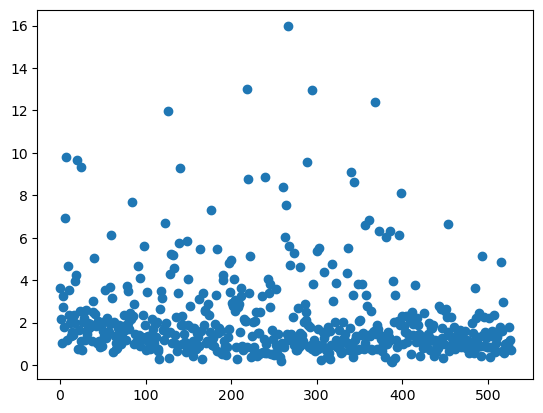

In [27]:
def inform_rate(mean_n, data, coun):
    return np.sum(data * np.log2((data / mean_n) + 0.0000001) * coun)


mean = np.mean(cluster, axis=0)

inform_rates = [inform_rate(mean[n], circ_rates[n, :], counts) for n in range(neurons)]

plt.scatter(range(neurons), inform_rates)
plt.show()

Then we pick the ones with an information rate higher then 0.2:

In [38]:
inform = 6
high_inform = np.where(np.array(inform_rates) > inform)[0]
print(high_inform)
len(high_inform)

[  6   7  20  24  60  84 123 126 140 176 219 220 239 261 263 264 267 289
 294 340 344 356 361 368 373 381 386 396 399 454]


30

Lets compute everything again but just with these neurons:

In [41]:
cluster_new = cluster[:, np.where(np.array(inform_rates) > inform)[0]]
data_new = activity[:, np.where(np.array(inform_rates) > inform)[0]]

layout_3d_cluster = umap.UMAP(
    n_components=3, verbose=False, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(cluster_new)

In [42]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=layout_3d_cluster[:, 0],
            y=layout_3d_cluster[:, 1],
            z=layout_3d_cluster[:, 2],
            mode="markers",
            marker=dict(
                size=12,
                color=f,
                colorscale="hsv",
                opacity=0.8,
                showscale=True,
            ),
        )
    ]
)
fig.update_layout(
    autosize=False, width=1000, height=700, margin=dict(l=0, r=0, b=0, t=0)
)
fig.write_html("circular_feature_3D_after_clustering.html")
fig.show()

In [52]:
cluster_new_crop = cluster_new[
    np.where(
        (np.array(layout_3d_cluster)[:, 0] > 9)
        & (np.array(layout_3d_cluster)[:, 1] < 7)
        & (np.array(layout_3d_cluster)[:, 2] > 4.8)
    )[0],
    :,
]
cluster_new_crop = cluster_new
layout_3d_new = umap.UMAP(
    n_components=3, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(cluster_new_crop)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=3, n_neighbors=20, verbose=True)
Tue Mar  8 23:50:15 2022 Construct fuzzy simplicial set
Tue Mar  8 23:50:15 2022 Finding Nearest Neighbors
Tue Mar  8 23:50:15 2022 Finished Nearest Neighbor Search
Tue Mar  8 23:50:15 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Tue Mar  8 23:50:17 2022 Finished embedding


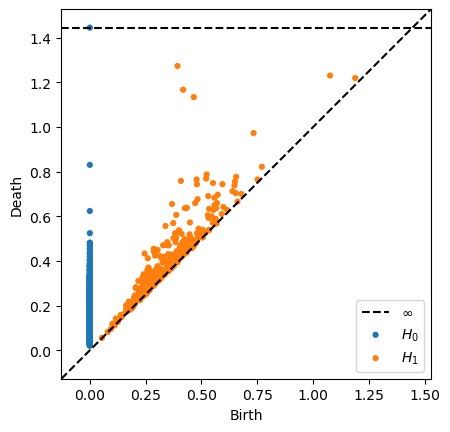

In [44]:
layout3 = umap.UMAP(
    n_components=len(high_inform),
    verbose=False,
    n_neighbors=20,
    min_dist=0.01,
    metric="cosine",
).fit_transform(cluster_new)
M = squareform(pdist(layout3, "euclidean"))
maxdim = 1
coeff = 47
thresh = np.max(M[~np.isinf(M)])
persistence = ripser(
    M, maxdim=maxdim, coeff=coeff, do_cocycles=True, distance_matrix=True, thresh=thresh
)
diagrams = persistence[
    "dgms"
]  # the multiset describing the lives of the persistence classes

plot_diagrams(diagrams, show=True)
cocycles = persistence["cocycles"][
    1
]  # the cocycle representatives for the 1-dim classes
births1 = diagrams[1][:, 0]  # the time of birth for the 1-dim classes
deaths1 = diagrams[1][:, 1]  # the time of death for the 1-dim classes
lives1 = deaths1 - births1  # the lifetime for the 1-dim classes
iMax = np.argsort(lives1)

threshold = births1[iMax[-1]] + (deaths1[iMax[-1]] - births1[iMax[-1]]) * (9 / 10)

cocycle = cocycles[iMax[-1]]

In [45]:
f_new, theta_matrix, verts_new, num_verts = get_coords(
    cocycle,
    threshold,
    len(layout3),
    M,
    47,
    "perea",  # "graph", "old", "perea"
)

number of vertices = 1213
number of edges = 84239


In [47]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=layout_3d_cluster[:, 0],
            y=layout_3d_cluster[:, 1],
            z=layout_3d_cluster[:, 2],
            mode="markers",
            marker=dict(
                size=12,
                color=f_new,
                colorscale="hsv",
                opacity=0.8,
                showscale=True,
            ),
        )
    ]
)
fig.update_layout(
    autosize=False, width=1000, height=700, margin=dict(l=0, r=0, b=0, t=0)
)
fig.write_html("circular_feature_3D_final.html")
fig.show()

In [49]:
circ_num = 2
threshold = births1[iMax[-circ_num]] + (
    deaths1[iMax[-circ_num]] - births1[iMax[-circ_num]]
) * (9 / 10)

cocycle = cocycles[iMax[-circ_num]]
f_2, theta_matrix, verts_new, num_verts = get_coords(
    cocycle,
    threshold,
    len(layout3),
    M,
    47,
    "perea",  # "graph", "old", "perea"
)
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=layout_3d_cluster[:, 0],
            y=layout_3d_cluster[:, 1],
            z=layout_3d_cluster[:, 2],
            mode="markers",
            marker=dict(
                size=12,
                color=f_2,
                colorscale="hsv",
                opacity=0.8,
                showscale=True,
            ),
        )
    ]
)
fig.update_layout(
    autosize=False, width=1000, height=700, margin=dict(l=0, r=0, b=0, t=0)
)
fig.write_html("circular_feature_3D_final_circ_2.html")
fig.show()

number of vertices = 1213
number of edges = 72409


In [50]:
circ_num = 3
threshold = births1[iMax[-circ_num]] + (
    deaths1[iMax[-circ_num]] - births1[iMax[-circ_num]]
) * (9 / 10)

cocycle = cocycles[iMax[-circ_num]]
f_3, theta_matrix, verts_new, num_verts = get_coords(
    cocycle,
    threshold,
    len(layout3),
    M,
    47,
    "perea",  # "graph", "old", "perea"
)
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=layout_3d_cluster[:, 0],
            y=layout_3d_cluster[:, 1],
            z=layout_3d_cluster[:, 2],
            mode="markers",
            marker=dict(
                size=12,
                color=f_3,
                colorscale="hsv",
                opacity=0.8,
                showscale=True,
            ),
        )
    ]
)
fig.update_layout(
    autosize=False, width=1000, height=700, margin=dict(l=0, r=0, b=0, t=0)
)
fig.write_html("circular_feature_3D_final_circ_3.html")
fig.show()

number of vertices = 1213
number of edges = 69008


We visulize the circle using using the lucent library. For that end we calculate average activation vectors for 50 overlapping patches along the circular parameter, Then we visulize those 50 average activation vectors. 

In [53]:
buckets = 10
linsp = np.linspace(f_new.min(), f_new.max(), buckets + 1)

clusters_overlap = []
for a in range(1, buckets):
    c = []
    for p in range(len(f_new)):
        if linsp[a - 1] < f_new[p] < linsp[a + 1]:
            c.append(cluster_new[p])
    clusters_overlap.append(c)

c = []
for p in range(len(f_new)):
    if linsp[buckets - 1] < f_new[p] or f_new[p] < linsp[1]:
        c.append(cluster_new[p])
clusters_overlap.append(c)
av_clusters_overlap = [np.mean(overlap, axis=0) for overlap in clusters_overlap]

print(list(map(lambda a: a.shape, av_clusters_overlap)))
print(list(map(len, clusters_overlap)))

[(30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,)]
[31, 144, 506, 601, 311, 150, 305, 285, 58, 33]


Using cache found in /Users/sturla/.cache/torch/hub/pytorch_vision_v0.10.0
100%|█████████████████████████████████████████████████████| 512/512 [01:02<00:00,  8.21it/s]



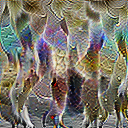

100%|█████████████████████████████████████████████████████| 512/512 [01:02<00:00,  8.14it/s]



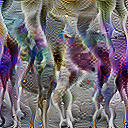

100%|█████████████████████████████████████████████████████| 512/512 [01:01<00:00,  8.28it/s]



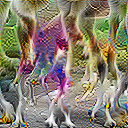

100%|█████████████████████████████████████████████████████| 512/512 [01:02<00:00,  8.13it/s]



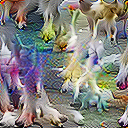

100%|█████████████████████████████████████████████████████| 512/512 [01:05<00:00,  7.82it/s]



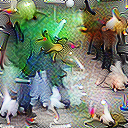

100%|█████████████████████████████████████████████████████| 512/512 [01:08<00:00,  7.47it/s]



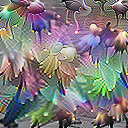

100%|█████████████████████████████████████████████████████| 512/512 [01:06<00:00,  7.69it/s]



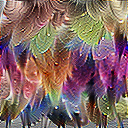

100%|█████████████████████████████████████████████████████| 512/512 [01:04<00:00,  7.94it/s]



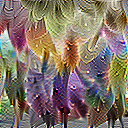

100%|█████████████████████████████████████████████████████| 512/512 [01:13<00:00,  6.94it/s]



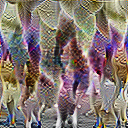

100%|█████████████████████████████████████████████████████| 512/512 [01:11<00:00,  7.13it/s]



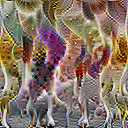

In [54]:
from lucent.optvis import render, param, transform, objectives

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.hub.load("pytorch/vision:v0.10.0", "googlenet", pretrained=True).eval()

pics = []
channel = lambda n: objectives.channel(layer, n)
for n in range(len(av_clusters_overlap)):
    a = []
    for m in range(len(high_inform)):
        a.append(av_clusters_overlap[n][m] * channel(high_inform[m]))
    obj = sum(a)
    d = render.render_vis(model, obj, show_inline=True)
    pics.append(d)

In [57]:
buckets = 10
linsp = np.linspace(f_2.min(), f_2.max(), buckets + 1)

clusters_overlap = []
for a in range(1, buckets):
    c = []
    for p in range(len(f_2)):
        if linsp[a - 1] < f_2[p] < linsp[a + 1]:
            c.append(cluster_new[p])
    clusters_overlap.append(c)

c = []
for p in range(len(f_new)):
    if linsp[buckets - 1] < f_2[p] or f_2[p] < linsp[1]:
        c.append(cluster_new[p])
clusters_overlap.append(c)
av_clusters_overlap = [np.mean(overlap, axis=0) for overlap in clusters_overlap]

print(list(map(lambda a: a.shape, av_clusters_overlap)))
print(list(map(len, clusters_overlap)))

[(30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,)]
[375, 371, 287, 234, 139, 344, 302, 133, 108, 131]


Using cache found in /Users/sturla/.cache/torch/hub/pytorch_vision_v0.10.0
100%|█████████████████████████████████████████████████████| 512/512 [01:06<00:00,  7.70it/s]



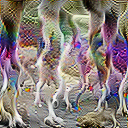

100%|█████████████████████████████████████████████████████| 512/512 [01:02<00:00,  8.22it/s]



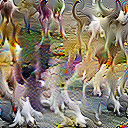

100%|█████████████████████████████████████████████████████| 512/512 [00:59<00:00,  8.63it/s]



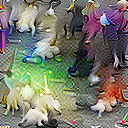

100%|█████████████████████████████████████████████████████| 512/512 [01:04<00:00,  7.97it/s]



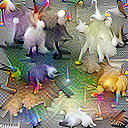

100%|█████████████████████████████████████████████████████| 512/512 [01:04<00:00,  7.96it/s]



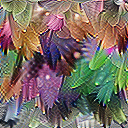

100%|█████████████████████████████████████████████████████| 512/512 [01:08<00:00,  7.48it/s]



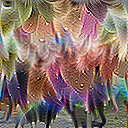

100%|█████████████████████████████████████████████████████| 512/512 [01:06<00:00,  7.64it/s]



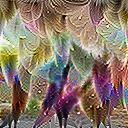

100%|█████████████████████████████████████████████████████| 512/512 [01:22<00:00,  6.20it/s]



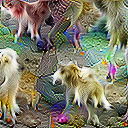

100%|█████████████████████████████████████████████████████| 512/512 [01:16<00:00,  6.72it/s]



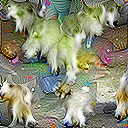

100%|█████████████████████████████████████████████████████| 512/512 [01:08<00:00,  7.44it/s]



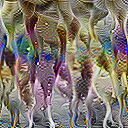

In [58]:
from lucent.optvis import render, param, transform, objectives

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.hub.load("pytorch/vision:v0.10.0", "googlenet", pretrained=True).eval()

pics_2 = []
channel = lambda n: objectives.channel(layer, n)
for n in range(len(av_clusters_overlap)):
    a = []
    for m in range(len(high_inform)):
        a.append(av_clusters_overlap[n][m] * channel(high_inform[m]))
    obj = sum(a)
    d = render.render_vis(model, obj, show_inline=True)
    pics_2.append(d)

In [59]:
buckets = 50
linsp = np.linspace(f_new.min(), f_new.max(), buckets + 1)

clusters_overlap = []
for a in range(1, buckets):
    c = []
    for p in range(len(f_new)):
        if linsp[a - 1] < f_new[p] < linsp[a + 1]:
            c.append(cluster_new[p])
    clusters_overlap.append(c)

c = []
for p in range(len(f_new)):
    if linsp[buckets - 1] < f_new[p] or f_new[p] < linsp[1]:
        c.append(cluster_new[p])
clusters_overlap.append(c)
av_clusters_overlap = [np.mean(overlap, axis=0) for overlap in clusters_overlap]

print(list(map(lambda a: a.shape, av_clusters_overlap)))
print(list(map(len, clusters_overlap)))

[(30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,)]
[2, 4, 12, 14, 6, 2, 3, 4, 8, 16, 30, 90, 83, 32, 52, 221, 210, 108, 131, 93, 78, 49, 86, 130, 103, 56, 35, 24, 9, 10, 13, 11, 27, 49, 40, 20, 9, 21, 216, 224, 34, 14, 9, 6, 8, 7, 3, 3, 4, 5]


Using cache found in /Users/sturla/.cache/torch/hub/pytorch_vision_v0.10.0
100%|█████████████████████████████████████████████████████| 512/512 [01:23<00:00,  6.11it/s]



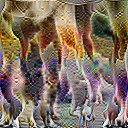

100%|█████████████████████████████████████████████████████| 512/512 [01:37<00:00,  5.25it/s]



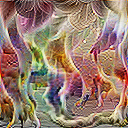

100%|█████████████████████████████████████████████████████| 512/512 [01:40<00:00,  5.10it/s]



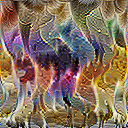

100%|█████████████████████████████████████████████████████| 512/512 [01:40<00:00,  5.09it/s]



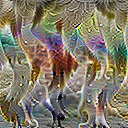

100%|█████████████████████████████████████████████████████| 512/512 [01:34<00:00,  5.39it/s]



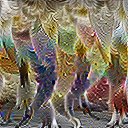

100%|█████████████████████████████████████████████████████| 512/512 [01:13<00:00,  7.01it/s]



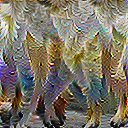

100%|█████████████████████████████████████████████████████| 512/512 [01:12<00:00,  7.07it/s]



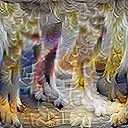

100%|█████████████████████████████████████████████████████| 512/512 [01:17<00:00,  6.56it/s]



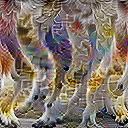

100%|█████████████████████████████████████████████████████| 512/512 [01:13<00:00,  6.99it/s]



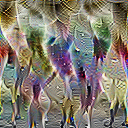

100%|█████████████████████████████████████████████████████| 512/512 [01:13<00:00,  6.98it/s]



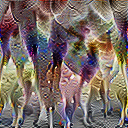

100%|█████████████████████████████████████████████████████| 512/512 [01:13<00:00,  6.98it/s]



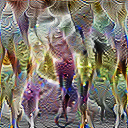

100%|█████████████████████████████████████████████████████| 512/512 [01:14<00:00,  6.90it/s]



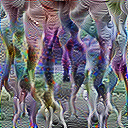

100%|█████████████████████████████████████████████████████| 512/512 [01:14<00:00,  6.89it/s]



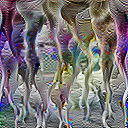

100%|█████████████████████████████████████████████████████| 512/512 [01:26<00:00,  5.90it/s]



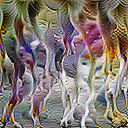

100%|█████████████████████████████████████████████████████| 512/512 [01:13<00:00,  6.93it/s]



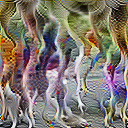

100%|█████████████████████████████████████████████████████| 512/512 [01:19<00:00,  6.47it/s]



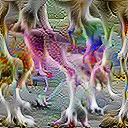

100%|█████████████████████████████████████████████████████| 512/512 [01:13<00:00,  7.01it/s]



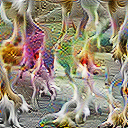

100%|█████████████████████████████████████████████████████| 512/512 [01:13<00:00,  6.98it/s]



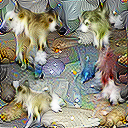

100%|█████████████████████████████████████████████████████| 512/512 [01:13<00:00,  7.01it/s]



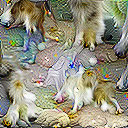

100%|█████████████████████████████████████████████████████| 512/512 [01:16<00:00,  6.72it/s]



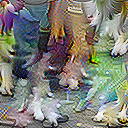

100%|█████████████████████████████████████████████████████| 512/512 [01:18<00:00,  6.52it/s]



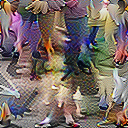

100%|█████████████████████████████████████████████████████| 512/512 [01:18<00:00,  6.49it/s]



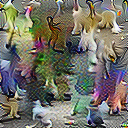

100%|█████████████████████████████████████████████████████| 512/512 [01:17<00:00,  6.61it/s]



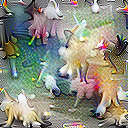

100%|█████████████████████████████████████████████████████| 512/512 [01:21<00:00,  6.31it/s]



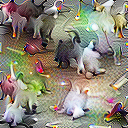

100%|█████████████████████████████████████████████████████| 512/512 [01:17<00:00,  6.59it/s]



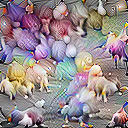

100%|█████████████████████████████████████████████████████| 512/512 [01:16<00:00,  6.68it/s]



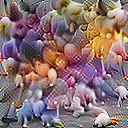

100%|█████████████████████████████████████████████████████| 512/512 [01:18<00:00,  6.49it/s]



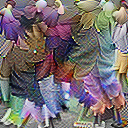

100%|█████████████████████████████████████████████████████| 512/512 [01:23<00:00,  6.16it/s]



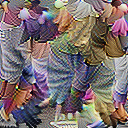

100%|█████████████████████████████████████████████████████| 512/512 [01:12<00:00,  7.11it/s]



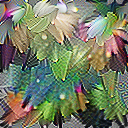

100%|█████████████████████████████████████████████████████| 512/512 [01:12<00:00,  7.03it/s]



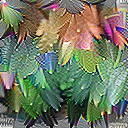

100%|█████████████████████████████████████████████████████| 512/512 [01:11<00:00,  7.18it/s]



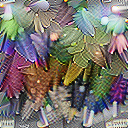

100%|█████████████████████████████████████████████████████| 512/512 [01:12<00:00,  7.10it/s]



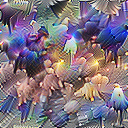

100%|█████████████████████████████████████████████████████| 512/512 [01:11<00:00,  7.17it/s]



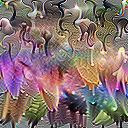

100%|█████████████████████████████████████████████████████| 512/512 [01:11<00:00,  7.18it/s]



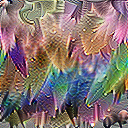

100%|█████████████████████████████████████████████████████| 512/512 [01:12<00:00,  7.05it/s]



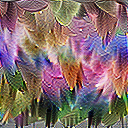

100%|█████████████████████████████████████████████████████| 512/512 [01:11<00:00,  7.13it/s]



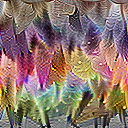

100%|█████████████████████████████████████████████████████| 512/512 [01:11<00:00,  7.17it/s]



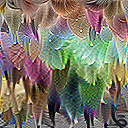

100%|█████████████████████████████████████████████████████| 512/512 [01:12<00:00,  7.03it/s]



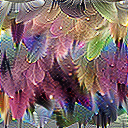

100%|█████████████████████████████████████████████████████| 512/512 [01:14<00:00,  6.83it/s]



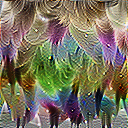

100%|█████████████████████████████████████████████████████| 512/512 [01:14<00:00,  6.90it/s]



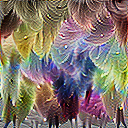

100%|█████████████████████████████████████████████████████| 512/512 [01:13<00:00,  7.00it/s]



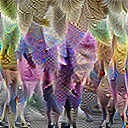

100%|█████████████████████████████████████████████████████| 512/512 [01:12<00:00,  7.09it/s]



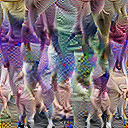

100%|█████████████████████████████████████████████████████| 512/512 [01:12<00:00,  7.07it/s]



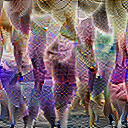

100%|█████████████████████████████████████████████████████| 512/512 [01:12<00:00,  7.08it/s]



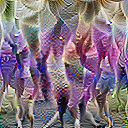

100%|█████████████████████████████████████████████████████| 512/512 [01:22<00:00,  6.17it/s]



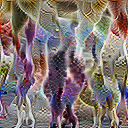

100%|█████████████████████████████████████████████████████| 512/512 [01:36<00:00,  5.33it/s]



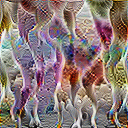

100%|█████████████████████████████████████████████████████| 512/512 [01:17<00:00,  6.59it/s]



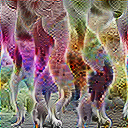

100%|█████████████████████████████████████████████████████| 512/512 [01:19<00:00,  6.47it/s]



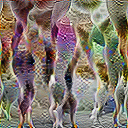

100%|█████████████████████████████████████████████████████| 512/512 [01:16<00:00,  6.67it/s]



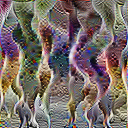

100%|█████████████████████████████████████████████████████| 512/512 [01:15<00:00,  6.81it/s]



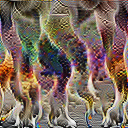

In [60]:
from lucent.optvis import render, param, transform, objectives

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.hub.load("pytorch/vision:v0.10.0", "googlenet", pretrained=True).eval()

pics_f = []
channel = lambda n: objectives.channel(layer, n)
for n in range(len(av_clusters_overlap)):
    a = []
    for m in range(len(high_inform)):
        a.append(av_clusters_overlap[n][m] * channel(high_inform[m]))
    obj = sum(a)
    d = render.render_vis(model, obj, show_inline=True)
    pics_f.append(d)

In [62]:
buckets = 40
linsp = np.linspace(f_2.min(), f_2.max(), buckets + 1)

clusters_overlap = []
for a in range(1, buckets):
    c = []
    for p in range(len(f_2)):
        if linsp[a - 1] < f_2[p] < linsp[a + 1]:
            c.append(cluster_new[p])
    clusters_overlap.append(c)

c = []
for p in range(len(f_new)):
    if linsp[buckets - 1] < f_2[p] or f_2[p] < linsp[1]:
        c.append(cluster_new[p])
clusters_overlap.append(c)
av_clusters_overlap = [np.mean(overlap, axis=0) for overlap in clusters_overlap]

print(list(map(lambda a: a.shape, av_clusters_overlap)))
print(list(map(len, clusters_overlap)))

[(30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,)]
[22, 92, 93, 37, 220, 216, 40, 58, 69, 65, 42, 23, 60, 107, 116, 80, 46, 26, 12, 17, 39, 67, 42, 13, 160, 242, 103, 36, 24, 13, 15, 10, 16, 54, 78, 43, 11, 6, 3, 8]


In [ ]:
from lucent.optvis import render, param, transform, objectives

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.hub.load("pytorch/vision:v0.10.0", "googlenet", pretrained=True).eval()

pics_f_2 = []
channel = lambda n: objectives.channel(layer, n)
for n in range(len(av_clusters_overlap)):
    a = []
    for m in range(len(high_inform)):
        a.append(av_clusters_overlap[n][m] * channel(high_inform[m]))
    obj = sum(a)
    d = render.render_vis(model, obj, show_inline=True)
    pics_f_2.append(d)

In [45]:
for i, im in enumerate(pics):
    np.save(f"data/circle_pics/circle_3/im_{i}.npy", im[0][0])

In [46]:
from PIL import Image

a = np.load("data/circle_pics/circle_3/im_1.npy")

a = (a * 255).astype(np.uint8)

ima = Image.fromarray(obj=a, mode="RGB")
ima.show()